In [2]:
from pyspark.sql import *
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf, col
from seaborn import *
import numpy as np
import tmdbsimple
# first import a few utility methods that we'll use later on
from IPython.display import Image, HTML, display
# check PySpark is running
import spark
spark

<module 'spark' from '/home/taingo/.local/lib/python3.10/site-packages/spark/__init__.py'>

In [3]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession



spark = SparkSession.builder \
    .appName("RecommendationFilm") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Specify the path to your CSV file
PATH_TO_DATA = "/home/taingo/Documents/ml-latest-small"

# Load ratings data using SparkSession
ratings = spark.read.csv(PATH_TO_DATA + "/ratings.csv", header=True, inferSchema=True)
ratings.cache()
print("Số lượng rating: {}".format(ratings.count()))

23/11/01 21:09:28 WARN Utils: Your hostname, taingo-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.80.130 instead (on interface ens33)
23/11/01 21:09:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/01 21:09:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/01 21:09:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Số lượng rating: 100836


In [4]:
ratings = ratings.select(
    ratings.userId, ratings.movieId, ratings.rating, (ratings.timestamp.cast("long") * 1000).alias("timestamp"))
ratings.show(6)

+------+-------+------+------------+
|userId|movieId|rating|   timestamp|
+------+-------+------+------------+
|     1|      1|   4.0|964982703000|
|     1|      3|   4.0|964981247000|
|     1|      6|   4.0|964982224000|
|     1|     47|   5.0|964983815000|
|     1|     50|   5.0|964982931000|
|     1|     70|   3.0|964982400000|
+------+-------+------+------------+
only showing top 6 rows



In [6]:
raw_movies = spark.read.csv(PATH_TO_DATA + "/movies.csv", header=True, inferSchema=True)
print("Các dòng dữ liệu của movies:")
raw_movies.show(5, truncate=False)

Các dòng dữ liệu của movies:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))

raw_movies.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



In [8]:
import re
# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    
# test out our function
s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

In [9]:
movies = raw_movies.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    extract_genres("genres").alias("genres"))
print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



In [10]:
link_data = spark.read.csv(PATH_TO_DATA + "/links.csv", header=True, inferSchema=True)
# join movies with links to get TMDB id
movie_data = movies.join(link_data, movies.movieId == link_data.movieId)\
    .select(movies.movieId, movies.title, movies.release_date, movies.genres, link_data.tmdbId)
num_movies = movie_data.count()
print("Làm sạch dữ liệu với  tmdbId links:")
movie_data.show(5, truncate=False)

Làm sạch dữ liệu với  tmdbId links:
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+-------------------------------------------------+

Successfully imported tmdbsimple!


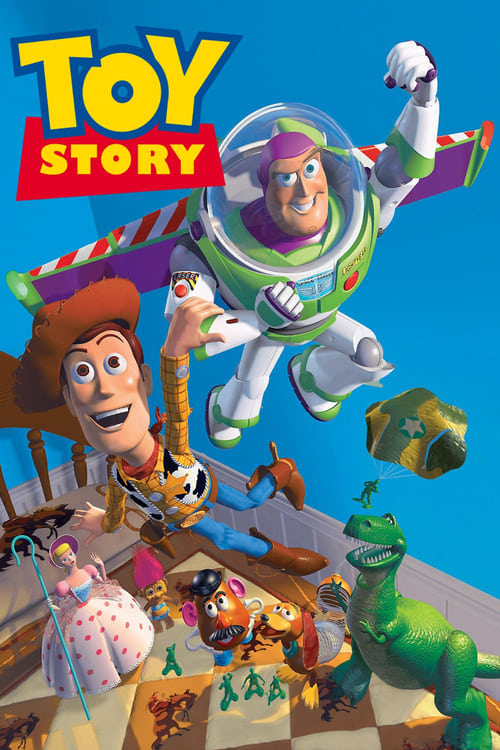

In [11]:
try:
    import tmdbsimple as tmdb
    import json
    from requests.exceptions import HTTPError
    tmdb.API_KEY = '6a1cf3f01fd70e17b5393ef1ba162909'
    print("Successfully imported tmdbsimple!")
    # base URL for TMDB poster images
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = movie_data.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except ImportError:
    print("Cannot import tmdbsimple as it is not installed, no movie posters will be displayed!")
except HTTPError as e:
    if e.response.status_code == 401:
        j = json.loads(e.response.text)
        print("TMdb API call failed: {}".format(j['status_message']))

Thanh Cong imported tmdbsimple!
Tên phim: The Dark


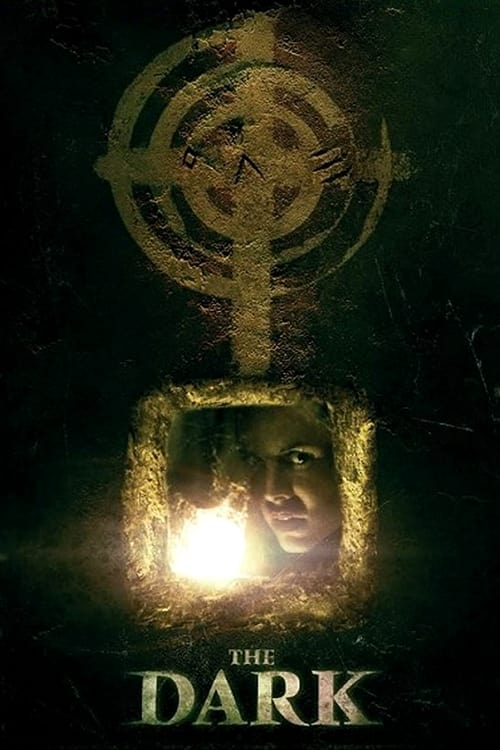

Tên phim: The Fifth Element


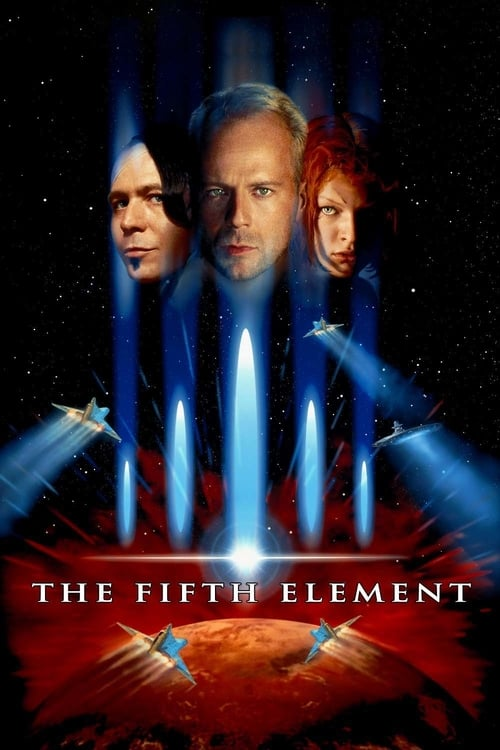

Tên phim: Metropolis


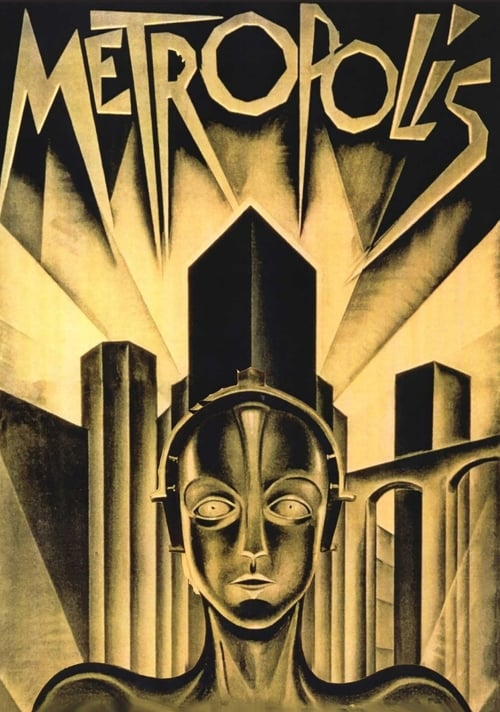

Tên phim: My Life Without Me


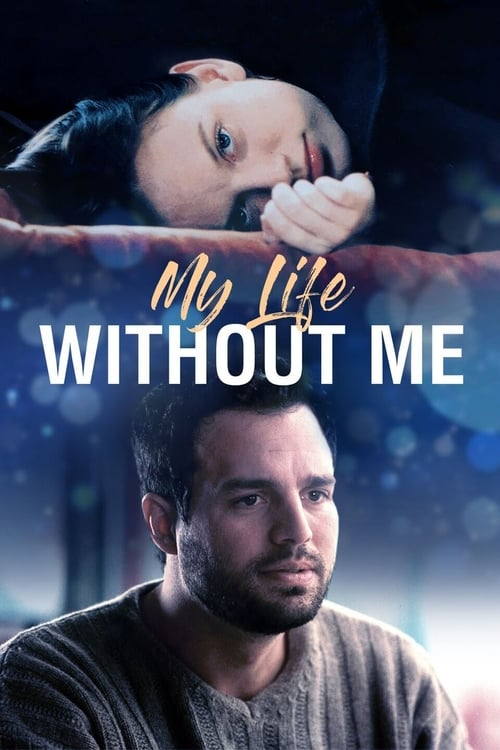

Tên phim: Pirates of the Caribbean: The Curse of the Black Pearl


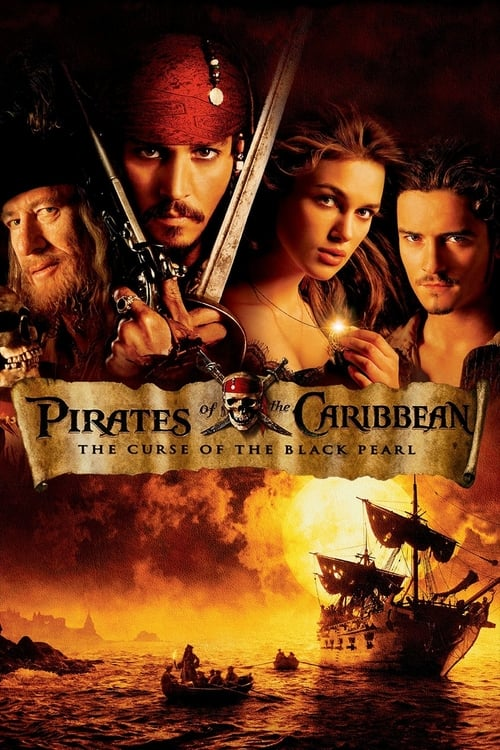

Tên phim: Kill Bill: Vol. 1


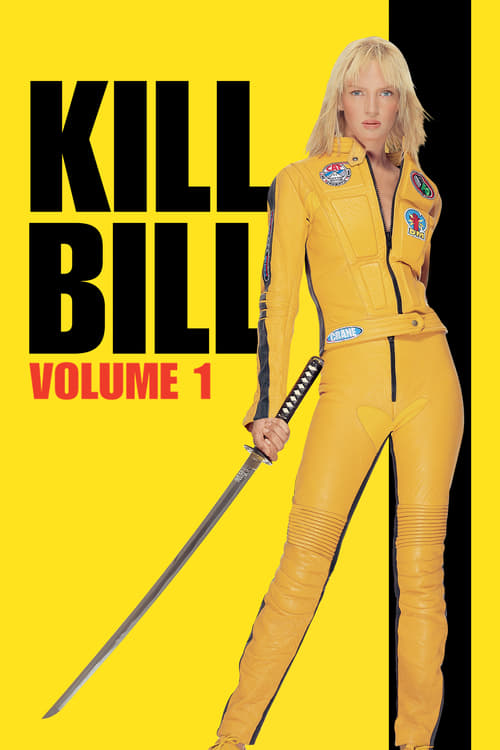

In [12]:
#  # Lấy tên của bộ phim
# movie_title = movie_info['title']
# movie_ids = [16, 2, 21, 11,69]
#   # Thay NEW_MOVIE_ID bằng id của bộ phim mới.
# movie_info = tmdb.Movies(movie_id).info()
#  for movie_id in movie_ids:
#         movie_info = tmdb.Movies(movie_id).info()
        
#         # Lấy tên của bộ phim
#         movie_title = movie_info['title']
        
#         # Lấy URL của ảnh bìa của bộ phim
#         movie_poster_url = IMAGE_URL + movie_info['poster_path']
        
#         # In tên của bộ phim
#         print("Tên phim:", movie_title)
# display(Image(movie_poster_url, width=200))

# #16, 2, 21, 11,69
try:
    import tmdbsimple as tmdb
    import json
    from requests.exceptions import HTTPError
    tmdb.API_KEY = '6a1cf3f01fd70e17b5393ef1ba162909'
    print("Thanh Cong imported tmdbsimple!")

    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'

    # Danh sách các ID của bộ phim bạn muốn xuất
    movie_ids = [17,18,19,20,22,24]

    for movie_id in movie_ids:
        movie_info = tmdb.Movies(movie_id).info()
        
        # Lấy tên của bộ phim
        movie_title = movie_info['title']
        
        # Lấy URL của ảnh bìa của bộ phim
        movie_poster_url = IMAGE_URL + movie_info['poster_path']
        
        # In tên của bộ phim
        print("Tên phim:", movie_title)
        
        # Hiển thị ảnh bìa của bộ phim
        display(Image(movie_poster_url, width=200))
    
except ImportError:
    print("Cannot import tmdbsimple as it is not installed, no movie posters will be displayed!")
except HTTPError as e:
    if e.response.status_code == 401:
        j = json.loads(e.response.text)
        print("TMdb API call failed: {}".format(j['status_message']))
#17,18,19,20,22,24

In [13]:
# from elasticsearch import Elasticsearch
# # test your ES instance is running
# es = Elasticsearch("http://localhost:9200")
# es.info(pretty=True)
from elasticsearch import Elasticsearch

# Create an Elasticsearch instance with the correct URL
es = Elasticsearch("http://localhost:9200")

# Test your ES instance is running and fetch information about the cluster
cluster_info = es.info(pretty=True)

# Print the cluster information
print(cluster_info)


{'name': 'taingo-virtual-machine', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'vBEsnH4oTdejS81kFlYmpw', 'version': {'number': '8.10.3', 'build_flavor': 'default', 'build_type': 'deb', 'build_hash': 'c63272efed16b5a1c25f3ce500715b7fddf9a9fb', 'build_date': '2023-10-05T10:15:55.152563867Z', 'build_snapshot': False, 'lucene_version': '9.7.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [14]:
 es.indices.delete(index="ratings,users,movies")

ObjectApiResponse({'acknowledged': True})

In [15]:
# set the factor vector dimension for the recommendation model
VECTOR_DIM = 20

create_ratings = {
    # this mapping definition sets up the fields for the rating events
    "mappings": {
        "properties": {
            "timestamp": {
                "type": "date"
            },
            "userId": {
                "type": "integer"
            },
            "movieId": {
                "type": "integer"
            },
            "rating": {
                "type": "double"
            }
        }  
    }
}

create_users = {
    # this mapping definition sets up the metadata fields for the users
    "mappings": {
        "properties": {
            "userId": {
                "type": "integer"
            },
            # the following fields define our model factor vectors and metadata
            "model_factor": {
                "type": "dense_vector",
                "dims" : VECTOR_DIM
            },
            "model_version": {
                "type": "keyword"
            },
            "model_timestamp": {
                "type": "date"
            }
        }
    }
}

create_movies = {
    # this mapping definition sets up the metadata fields for the movies
    "mappings": {
        "properties": {
            "movieId": {
                "type": "integer"
            },
            "tmdbId": {
                "type": "keyword"
            },
            "genres": {
                "type": "keyword"
            },
            "release_date": {
                "type": "date",
                "format": "year"
            },
            # the following fields define our model factor vectors and metadata
            "model_factor": {
                "type": "dense_vector",
                "dims" : VECTOR_DIM
            },
            "model_version": {
                "type": "keyword"
            },
            "model_timestamp": {
                "type": "date"
            }          
        }
    }
}

# create indices with the settings and mappings above
res_ratings = es.indices.create(index="ratings", body=create_ratings)
res_users = es.indices.create(index="users", body=create_users)
res_movies = es.indices.create(index="movies", body=create_movies)

print("Created indices:")
print(res_ratings)
print(res_users)
print(res_movies)

Created indices:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'ratings'}
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'users'}
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'movies'}


In [16]:
from elasticsearch import Elasticsearch

# Kết nối với Elasticsearch
es = Elasticsearch(["http://localhost:9200"])

# Lấy dữ liệu từ DataFrame dưới dạng danh sách từ điển (dict)
data = ratings.rdd.map(lambda row: row.asDict()).collect()

# Ghi dữ liệu vào Elasticsearch
for doc in data:
    es.index(index="ratings", body=doc)

# Kiểm tra số lượng bản ghi trong Elasticsearch
num_ratings_es = es.count(index="ratings")['count']
num_ratings_df = len(data)  # Số lượng bản ghi trong danh sách

# Kiểm tra kết quả
print("Dataframe count: {}".format(num_ratings_df))
print("ES index count:  {}".format(num_ratings_es))

Dataframe count: 100836
ES index count:  100836


In [17]:
es.search(index="ratings", q="*", size=3)

ObjectApiResponse({'took': 683, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 1.0, 'hits': [{'_index': 'ratings', '_id': '0m0_i4sBasOA5Spzzr2S', '_score': 1.0, '_source': {'userId': 225, 'movieId': 2361, 'rating': 1.0, 'timestamp': 949111637000}}, {'_index': 'ratings', '_id': '020_i4sBasOA5Spzzr2c', '_score': 1.0, '_source': {'userId': 225, 'movieId': 2371, 'rating': 4.0, 'timestamp': 949111535000}}, {'_index': 'ratings', '_id': '1G0_i4sBasOA5Spzzr2g', '_score': 1.0, '_source': {'userId': 225, 'movieId': 2396, 'rating': 5.0, 'timestamp': 949111497000}}]}})

In [18]:
es.count(index="ratings", q="timestamp:[2018-01-01 TO 2018-02-01]")

ObjectApiResponse({'count': 952, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

In [19]:
from elasticsearch import Elasticsearch

# Kết nối với Elasticsearch
es = Elasticsearch(["http://localhost:9200"])

# Lấy dữ liệu từ DataFrame dưới dạng danh sách từ điển (dict)
data = ratings.rdd.map(lambda row: row.asDict()).collect()

# Ghi dữ liệu vào Elasticsearch
for doc in data:
    es.index(index="movies", body=doc)

# Kiểm tra số lượng bản ghi trong Elasticsearch
num_ratings_es = es.count(index="movies")['count']
num_ratings_df = len(data)  # Số lượng bản ghi trong danh sách

# Kiểm tra kết quả
print("Dataframe count: {}".format(num_ratings_df))
print("ES index count:  {}".format(num_ratings_es))

Dataframe count: 100836
ES index count:  100836


In [20]:
# test things out by searching for movies containing "matrix" in the title
es.search(index="movies", q="title:matrix", size=3)

ObjectApiResponse({'took': 42, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 0, 'relation': 'eq'}, 'max_score': None, 'hits': []}})

In [28]:
import requests
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("MyApp").getOrCreate()

# Define Elasticsearch index and query
es_index = "ratings"  # Replace with your Elasticsearch index name
es_url = "http://localhost:9200"  # Replace with your Elasticsearch node URL

# Define the Elasticsearch query
es_query = {
    "query": {
        "match_all": {}  # Your query here
    }
}

# Use the Elasticsearch REST API to fetch data
response = requests.post(f"{es_url}/{es_index}/_search", json=es_query)

# Convert the JSON response to a Spark DataFrame
if response.status_code == 200:
    data = response.json()["hits"]["hits"]
    ratings_df = spark.createDataFrame(data)
else:
    print("Error fetching data from Elasticsearch")

# Show the first 5 rows of the DataFrame
ratings_df.show(5)

# Stop the Spark session
spark.stop()


23/11/01 21:57:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+--------------------+-------+------+--------------------+
|                 _id| _index|_score|             _source|
+--------------------+-------+------+--------------------+
|0m0_i4sBasOA5Spzzr2S|ratings|   1.0|{rating -> NULL, ...|
|020_i4sBasOA5Spzzr2c|ratings|   1.0|{rating -> NULL, ...|
|1G0_i4sBasOA5Spzzr2g|ratings|   1.0|{rating -> NULL, ...|
|1W0_i4sBasOA5Spzzr2o|ratings|   1.0|{rating -> NULL, ...|
|1m0_i4sBasOA5Spzzr2r|ratings|   1.0|{rating -> NULL, ...|
+--------------------+-------+------+--------------------+
only showing top 5 rows



In [40]:
import implicit
import scipy.sparse as sp

# Sample user-item interaction data represented as a sparse matrix
# Replace this with your actual user-item interaction data
# In this example, we have a binary matrix where 1 indicates interaction
interactions = sp.csr_matrix([
    [1, 0, 1, 0],
    [0, 1, 1, 0],
    [1, 0, 0, 1],
])

# Create an Alternating Least Squares (ALS) model
model = implicit.als.AlternatingLeastSquares(factors=32)

# Fit the model to the user-item interaction matrix
model.fit(interactions)

# Now, the model is trained and ready for making recommendations.


/home/taingo/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [18]:
ratings_from_es = spark.read.format("es").load("ratings")
ratings_from_es.show(5)

+-------+------+-------------------+------+
|movieId|rating|          timestamp|userId|
+-------+------+-------------------+------+
|      1|   4.0|2000-07-30 20:45:03|     1|
|      3|   4.0|2000-07-30 20:20:47|     1|
|      6|   4.0|2000-07-30 20:37:04|     1|
|     47|   5.0|2000-07-30 21:03:35|     1|
|     50|   5.0|2000-07-30 20:48:51|     1|
+-------+------+-------------------+------+
only showing top 5 rows



In [19]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", regParam=0.02, rank=VECTOR_DIM, seed=54)
model = als.fit(ratings_from_es)
model.userFactors.show(5)
model.itemFactors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.13299428, 0.42...|
| 20|[0.2196542, -0.28...|
| 30|[-0.58235997, 0.1...|
| 40|[0.31613937, -0.2...|
| 50|[0.3011615, 0.112...|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.6092093, 0.570...|
| 20|[0.12555358, -0.2...|
| 30|[0.9184103, 0.465...|
| 40|[0.40230548, 0.53...|
| 50|[0.56450856, 0.10...|
+---+--------------------+
only showing top 5 rows



In [20]:
from pyspark.sql.functions import lit, current_timestamp, unix_timestamp
ver = model.uid
ts = unix_timestamp(current_timestamp())
movie_vectors = model.itemFactors.select("id",\
                                         col("features").alias("model_factor"),\
                                         lit(ver).alias("model_version"),\
                                         ts.alias("model_timestamp"))
movie_vectors.show(5)
user_vectors = model.userFactors.select("id",\
                                        col("features").alias("model_factor"),\
                                        lit(ver).alias("model_version"),\
                                        ts.alias("model_timestamp"))
user_vectors.show(5)

+---+--------------------+----------------+---------------+
| id|        model_factor|   model_version|model_timestamp|
+---+--------------------+----------------+---------------+
| 10|[0.6092093, 0.570...|ALS_b289ae1d349c|     1585732983|
| 20|[0.12555358, -0.2...|ALS_b289ae1d349c|     1585732983|
| 30|[0.9184103, 0.465...|ALS_b289ae1d349c|     1585732983|
| 40|[0.40230548, 0.53...|ALS_b289ae1d349c|     1585732983|
| 50|[0.56450856, 0.10...|ALS_b289ae1d349c|     1585732983|
+---+--------------------+----------------+---------------+
only showing top 5 rows

+---+--------------------+----------------+---------------+
| id|        model_factor|   model_version|model_timestamp|
+---+--------------------+----------------+---------------+
| 10|[0.13299428, 0.42...|ALS_b289ae1d349c|     1585732983|
| 20|[0.2196542, -0.28...|ALS_b289ae1d349c|     1585732983|
| 30|[-0.58235997, 0.1...|ALS_b289ae1d349c|     1585732983|
| 40|[0.31613937, -0.2...|ALS_b289ae1d349c|     1585732983|
| 50|[0.3011615

In [21]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "update" write mode for ES, since you want to update new fields only
# - "append" write mode for Spark
movie_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("movies", mode="append")

In [22]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "index" write mode for ES, since you have not written to the user index previously
# - "append" write mode for Spark
user_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "index") \
    .save("users", mode="append")

### Check the data  was written correctly

You can search for a movie to see if the model factor vector was written correctly. You should see a `'model_factor': [0..188..., ]` field in the returned movie document, as well as a `model_version` and `model_timestamp` field).

In [23]:
# search for a particular sci-fi movie
es.search(index="movies", q="force awakens")['hits']['hits'][0]

{'_index': 'movies',
 '_type': '_doc',
 '_id': '122886',
 '_score': 10.524785,
 '_source': {'movieId': 122886,
  'title': 'Star Wars: Episode VII - The Force Awakens',
  'release_date': '2015',
  'genres': ['action', 'adventure', 'fantasy', 'sci-fi', 'imax'],
  'tmdbId': 140607,
  'model_timestamp': 1585732985,
  'model_version': 'ALS_b289ae1d349c',
  'model_factor': [0.18812202,
   0.7076669,
   -1.3437241,
   -0.3083917,
   0.31944987,
   0.45389917,
   -0.8027336,
   -0.66270983,
   1.2934446,
   -0.12376652,
   0.5889607,
   -0.12555946,
   -1.1881688,
   0.60742664,
   1.0457083,
   0.564867,
   0.89669603,
   1.1521518,
   -0.39917782,
   -2.687924],
  'id': 122886}}

In [24]:
from IPython.display import Image, HTML, display

def get_poster_url(id):
    """Fetch movie poster image URL from TMDb API given a tmdbId"""
    
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    try:
        import tmdbsimple as tmdb
        from tmdbsimple import APIKeyError
        try:
            movie = tmdb.Movies(id).info()
            poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        return "NA"
    
    
def vector_query(query_vec, vector_field, q="*", cosine=False):
    """
    Construct an Elasticsearch script score query using `dense_vector` fields
    
    The script score query takes as parameters the query vector (as a Python list)
    
    Parameters
    ----------
    query_vec : list
        The query vector
    vector_field : str
        The field name in the document against which to score `query_vec`
    q : str, optional
        Query string for the search query (default: '*' to search across all documents)
    cosine : bool, optional
        Whether to compute cosine similarity. If `False` then the dot product is computed (default: False)
     
    Note: Elasticsearch cannot rank negative scores. Therefore, in the case of the dot product, a sigmoid transform
    is applied. In the case of cosine similarity, 1.0 is added to the score. In both cases, documents with no 
    factor vectors are ignored by applying a 0.0 score.
    
    The query vector passed in will be the user factor vector (if generating recommended movies for a user)
    or movie factor vector (if generating similar movies for a given movie)
    """
    
    if cosine:
        score_fn = "doc['{v}'].size() == 0 ? 0 : cosineSimilarity(params.vector, '{v}') + 1.0"
    else:
        score_fn = "doc['{v}'].size() == 0 ? 0 : sigmoid(1, Math.E, -dotProduct(params.vector, '{v}'))"
       
    score_fn = score_fn.format(v=vector_field, fn=score_fn)
    
    return {
    "query": {
        "script_score": {
            "query" : { 
                "query_string": {
                    "query": q
                }
            },
            "script": {
                "source": score_fn,
                "params": {
                    "vector": query_vec
                }
            }
        }
    }
}


def get_similar(the_id, q="*", num=10, index="movies", vector_field='model_factor'):
    """
    Given a movie id, execute the recommendation script score query to find similar movies,
    ranked by cosine similarity. We return the `num` most similar, excluding the movie itself.
    """
    response = es.get(index=index, id=the_id)
    src = response['_source']
    if vector_field in src:
        query_vec = src[vector_field]
        q = vector_query(query_vec, vector_field, q=q, cosine=True)
        results = es.search(index=index, body=q)
        hits = results['hits']['hits']
        return src, hits[1:num+1]
    
    
def get_user_recs(the_id, q="*", num=10, users="users", movies="movies", vector_field='model_factor'):
    """
    Given a user id, execute the recommendation script score query to find top movies, ranked by predicted rating
    """
    response = es.get(index=users, id=the_id)
    src = response['_source']
    if vector_field in src:
        query_vec = src[vector_field]
        q = vector_query(query_vec, vector_field, q=q, cosine=False)
        results = es.search(index=movies, body=q)
        hits = results['hits']['hits']
        return src, hits[:num]

def get_movies_for_user(the_id, num=10, ratings="ratings", movies="movies"):
    """
    Given a user id, get the movies rated by that user, from highest- to lowest-rated.
    """
    response = es.search(index=ratings, q="userId:{}".format(the_id), size=num, sort=["rating:desc"])
    hits = response['hits']['hits']
    ids = [h['_source']['movieId'] for h in hits]
    movies = es.mget(body={"ids": ids}, index=movies, _source_includes=['tmdbId', 'title'])
    movies_hits = movies['docs']
    tmdbids = [h['_source'] for h in movies_hits]
    return tmdbids

            
def display_user_recs(the_id, q="*", num=10, num_last=10, users="users", movies="movies", ratings="ratings"):
    user, recs = get_user_recs(the_id, q, num, users, movies)
    user_movies = get_movies_for_user(the_id, num_last, ratings, movies)
    # check that posters can be displayed
    first_movie = user_movies[0]
    first_im_url = get_poster_url(first_movie['tmdbId'])
    if first_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if first_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    # display the movies that this user has rated highly
    display(HTML("<h2>Get recommended movies for user id %s</h2>" % the_id))
    display(HTML("<h4>The user has rated the following movies highly:</h4>"))
    user_html = "<table border=0>"
    i = 0
    for movie in user_movies:
        movie_im_url = get_poster_url(movie['tmdbId'])
        movie_title = movie['title']
        user_html += "<td><h5>%s</h5><img src=%s width=150></img></td>" % (movie_title, movie_im_url)
        i += 1
        if i % 5 == 0:
            user_html += "</tr><tr>"
    user_html += "</tr></table>"
    display(HTML(user_html))
    # now display the recommended movies for the user
    display(HTML("<br>"))
    display(HTML("<h2>Recommended movies:</h2>"))
    rec_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))

    
def display_similar(the_id, q="*", num=10, movies="movies"):
    """
    Display query movie, together with similar movies and similarity scores, in a table
    """
    movie, recs = get_similar(the_id, q, num, movies)
    q_im_url = get_poster_url(movie['tmdbId'])
    if q_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if q_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    display(HTML("<h2>Get similar movies for:</h2>"))
    display(HTML("<h4>%s</h4>" % movie['title']))
    if q_im_url != "NA":
        display(Image(q_im_url, width=200))
    display(HTML("<br>"))
    display(HTML("<h2>People who liked this movie also liked these:</h2>"))
    sim_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        sim_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            sim_html += "</tr><tr>"
    sim_html += "</tr></table>"
    display(HTML(sim_html))

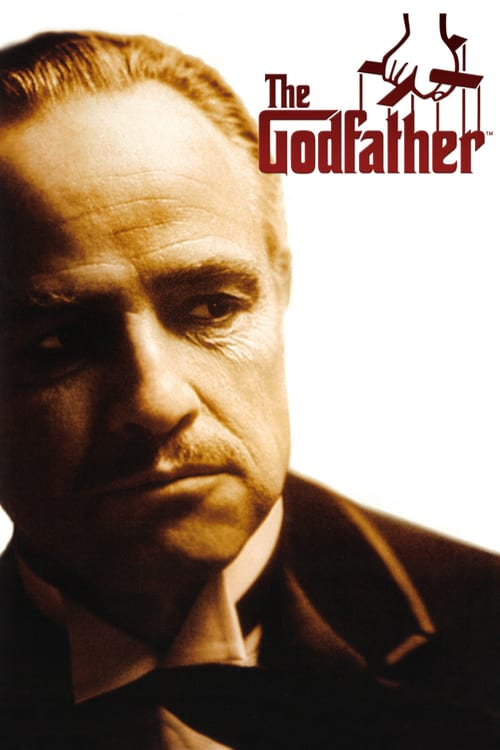

In [25]:
display_similar(858, num=5)

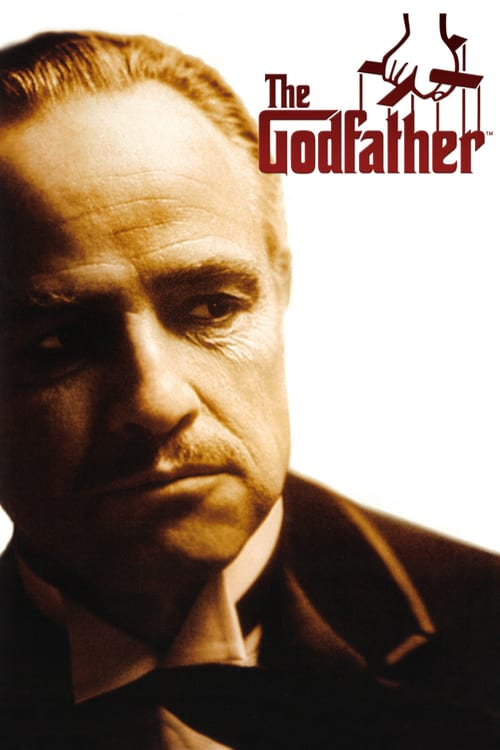

In [26]:
display_similar(858, num=5, q="title:(NOT godfather)")

We see that we now only have similar movies that are _not also part of the Godfather trilogy_.

#### Filter recommendations based on genre

Or you may want to ensure that only valid children's movies are shown to young viewers.

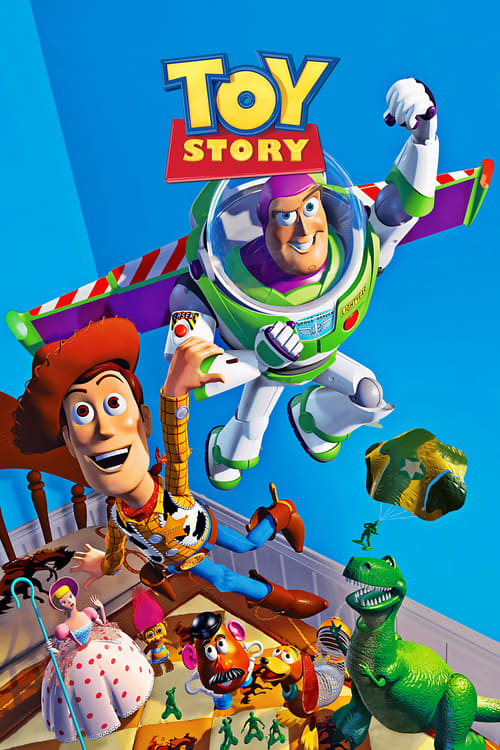

In [27]:
display_similar(1, num=5, q="genres:children")

Feel free to check out the documentation for the Elasticsearch [query string query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-query-string-query.html) and play around with the various queries you can construct by passing in a query string as `q` in the recommendation function above!

In [28]:
display_user_recs(72, num=5, num_last=5)

In [29]:
display_user_recs(72, num=5, num_last=5, q="release_date:[2017 TO *]")